<a href="https://colab.research.google.com/github/mcoudreau/Python/blob/Master/Coudreau_Manon_10_Detection_faux_billets_032023_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONTEXTE ET OBJECTIF**

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM souhaite renforcer ses méthodes d’identification des contrefaçons des billets en euros et pour cela nous confie la mission :



1.   De mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.
2.    L’algorithme doit pouvoir différencier les vrais des faux billets à partir des caractéristique géométriques de ces derniers


# **I. Importation des librairies et des données**

In [228]:
# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import scipy.stats as st
from sklearn.model_selection import train_test_split


# Pour la regression lineaire:
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Pour les graphiques : 
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns


# Pour la regression logistique:
from sklearn.linear_model import LogisticRegression

# Pour Kmeans
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix


In [318]:
# Lecture et séparation des données
dataset = pd.read_csv('/content/billets.csv',sep = ';')
billets = dataset.copy()
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


6 dimensions géométriques sur un billet



*   length : la longueur du billet (en mm)
*  height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm)
*   height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
*  margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
*   margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm)
*  diagonal : la diagonale du billet (en mm)


# **II. Phase d'exploration des données**
L'objectif de l'exploration :


*   Comprendre nos données
*   Développer une premiere stratégie de modélisation






1.  Exploration



In [230]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [231]:
billets.shape

(1500, 7)

In [232]:
# vérifier les valeurs que prend la colonne is_genuine
billets['is_genuine'].unique()

array([ True, False])

In [233]:
# Encoder la variable is_genuine pour avoir que des variables numériques 
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54




*   0 = faux
*   1 = vrai


Text(0.5, 1.0, 'Taux des vrais et faux billets')

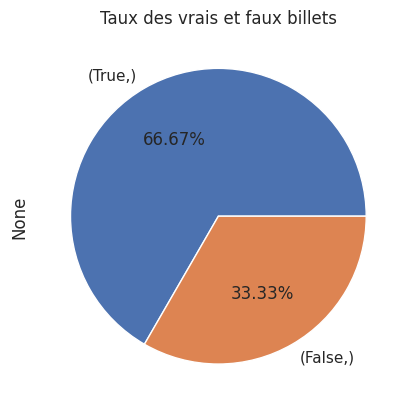

In [319]:
# afficher les taux de faux billets et des vrais billets
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')

In [234]:
# afficher les moyennes de variables
billets.mean()

is_genuine        0.666667
diagonal        171.958440
height_left     104.029533
height_right    103.920307
margin_low        4.485967
margin_up         3.151473
length          112.678500
dtype: float64


2.   Exploration des valeurs aberrantes/atypiques de la variable margin_up



In [235]:
# Vérification des valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 valeurs manquantes pour la variable margin_low

<Axes: ylabel='margin_up'>

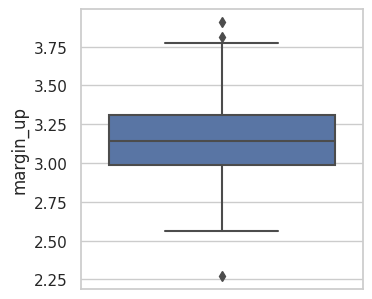

In [236]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')


3.   Exploration des paramètres statistiques (boxplots)

<Axes: ylabel='margin_low'>

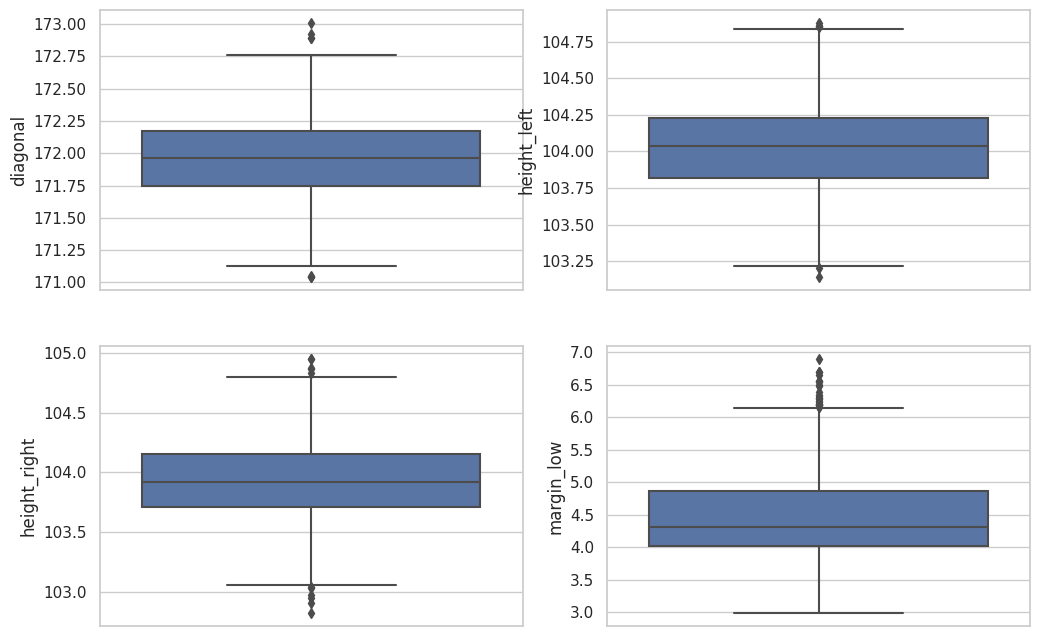

In [237]:
# Afficher des boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low')

<Axes: ylabel='length'>

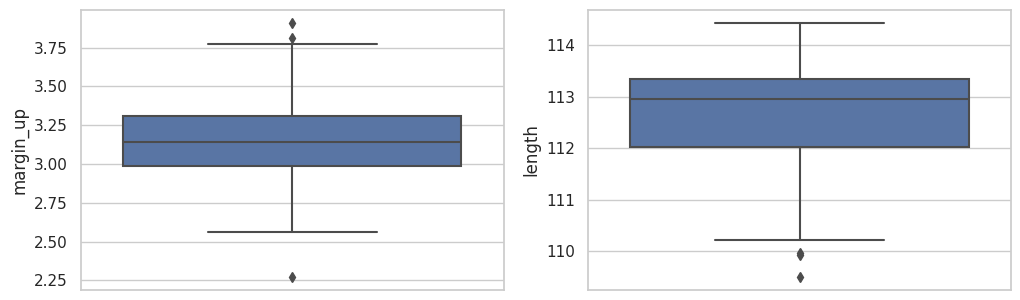

In [238]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')
plt.subplot(222)
sns.boxplot(data=billets,  y='length')

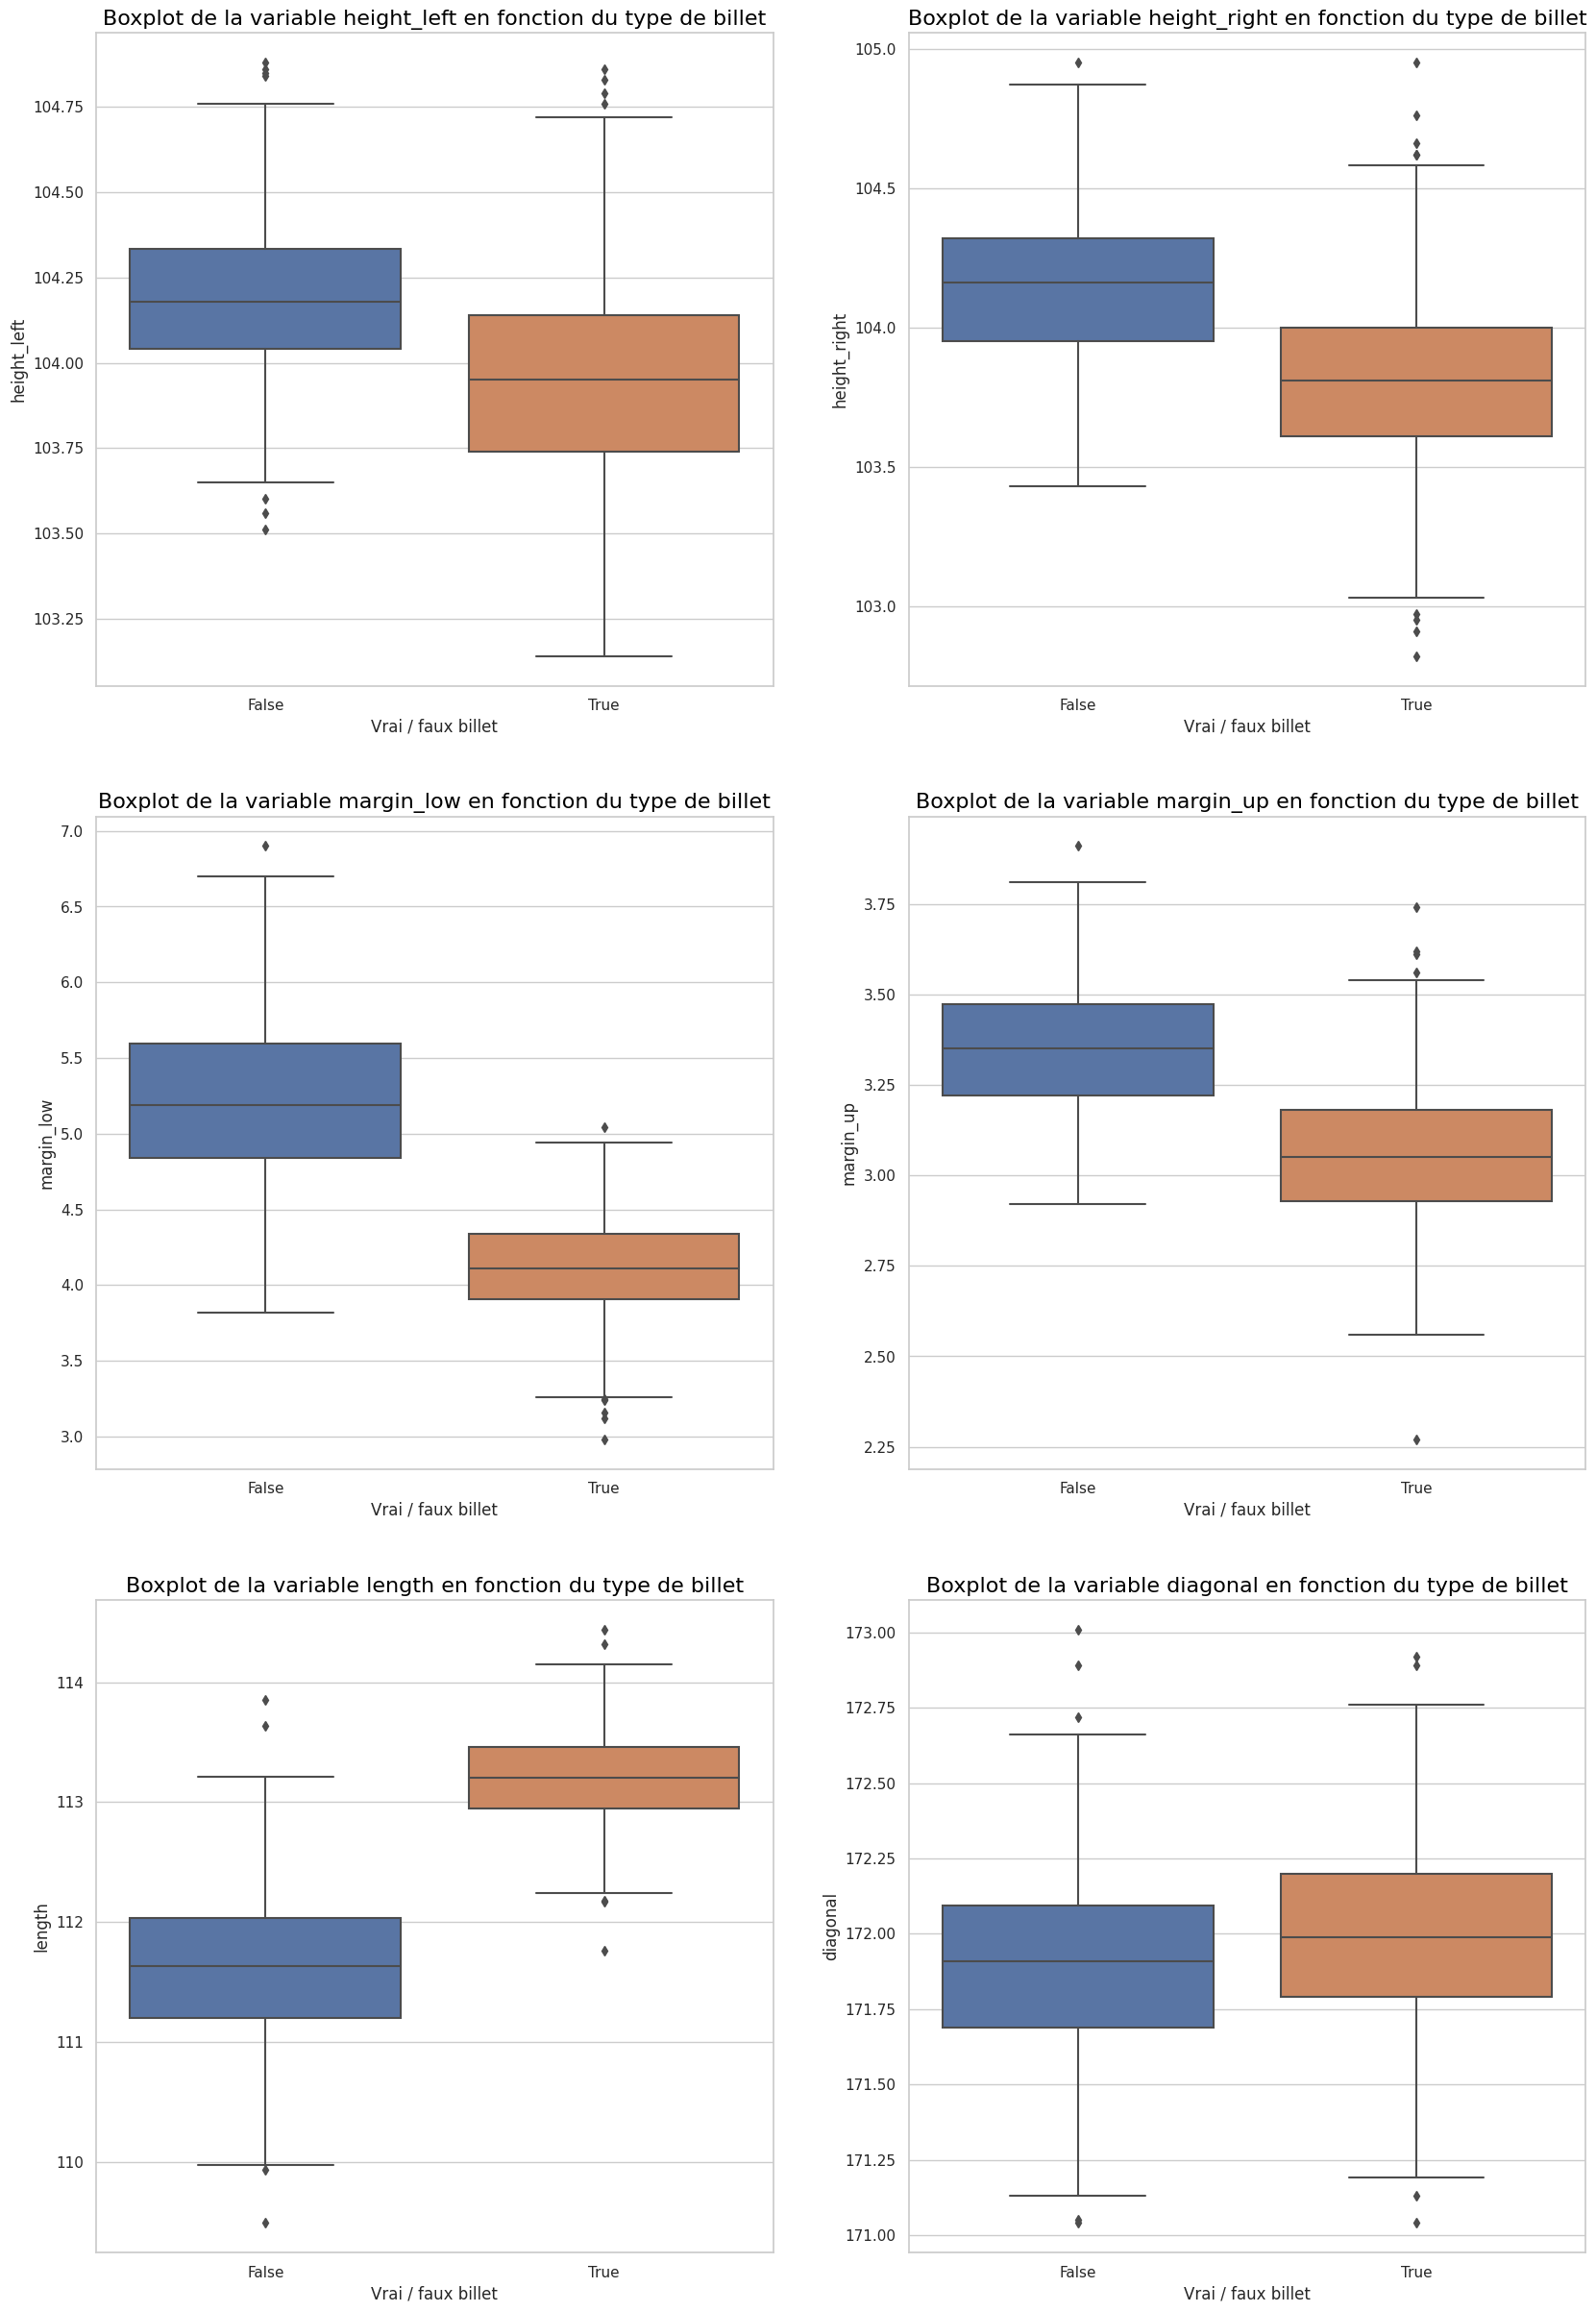

In [239]:
def var_boxplot(var, i):
    ax = fig.add_subplot(i)
    ax = sns.boxplot(x="is_genuine", y=var, data=dataset)
    plt.xlabel('Vrai / faux billet')
    plt.ylabel(var)
    plt.title('Boxplot de la variable '+str(var)+' en fonction du type de billet', color="black", size=16)

liste_var = ["height_left","height_right","margin_low","margin_up","length","diagonal"]

fig = plt.figure(figsize=(20,30),constrained_layout=False)
i = 321
for var in liste_var :
    var_boxplot(var, i)
    i+=1

<Figure size 100x100 with 0 Axes>

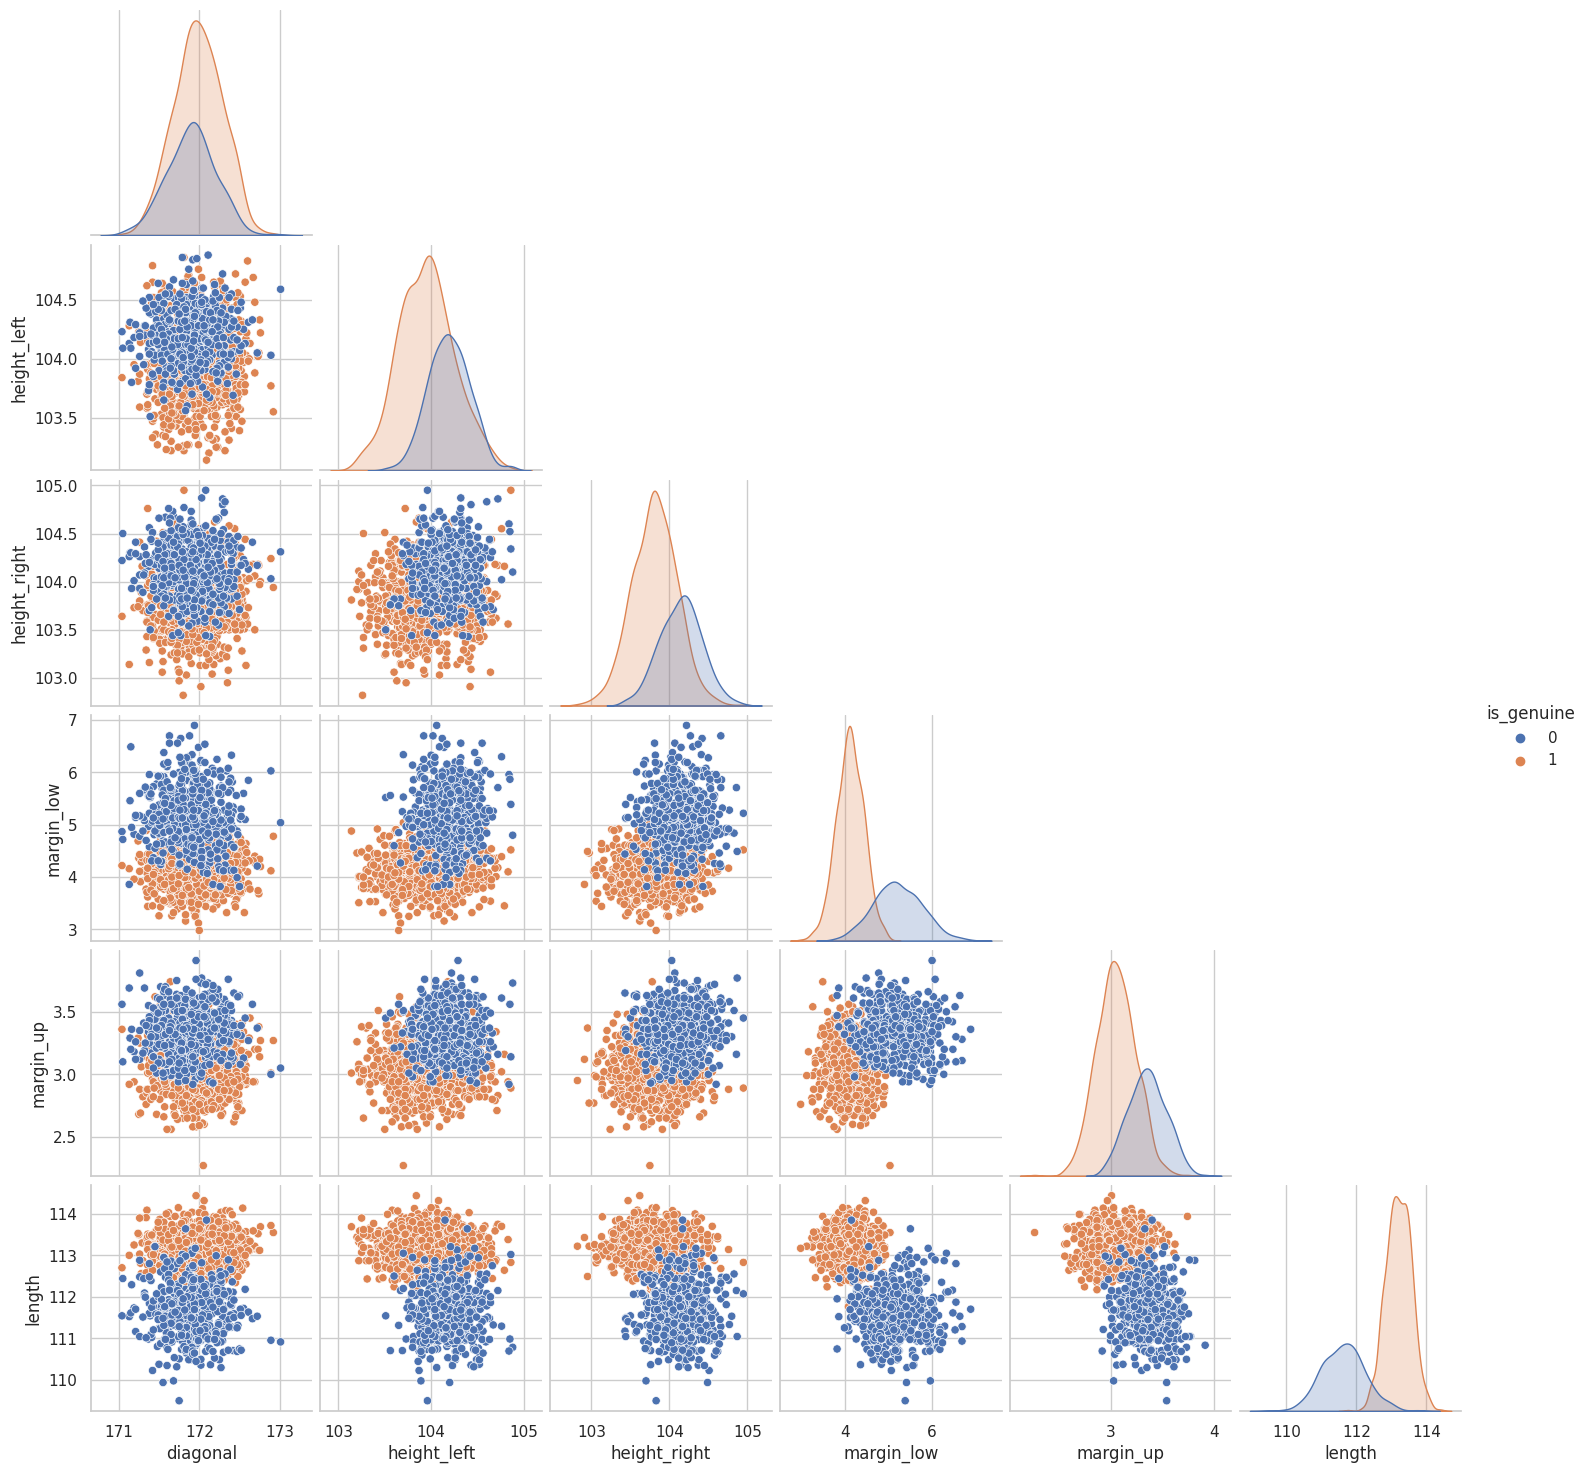

In [317]:
# Pairplots pour identifier les frais et faux billets
plt.figure(figsize=(1, 1))
sns.pairplot(billets,hue='is_genuine',corner=True)


4.   Exploration de la matrice des correlations



In [240]:
# Afficher la matrice de corrélation
matrice_correlation = billets.corr()
matrice_correlation.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


Text(0.5, 1.0, 'Corrélation entre les différentes variables')

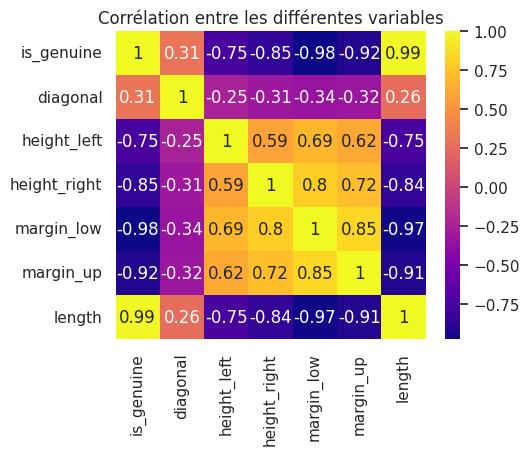

In [241]:
# heatmap de corrélations entre les différentes variables
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_correlation.corr(),cmap='plasma', annot=True)
plt.title('Corrélation entre les différentes variables')

In [242]:
billets.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000



CONCLUSION
*   ID : is_genuine
*   Nous avons 1 500 données et 7 colonnes
*   Nous avons 37 données nulles
*   Nous avons 6 variables quantitatives et 1 variable qualitative







Il y a des données manquantes, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.

# **III. Regression linéaire : combler les valeurs manquantes**
Nous allons créer deuxx DF : 
*   Dataset training : un DF avec sans valeur manquantes que nous utiliserons pour notre régression liniéaire
*   Dataset testing :  un dataframe avec uniquement les valeurs manquantes pour appliquer notre modèle






1.   Création de deux DF



In [245]:
# dataset sans les valeurs manquantes
df_training  = billets.dropna()
df_training.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [246]:
# dataset avec les valeurs manquantes
df_testing = billets.loc[billets['margin_low'].isnull(),['is_genuine','diagonal','height_left','height_right','margin_up','length']]
df_testing.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36




2.   OLS - Regression linéaire backward



In [247]:
# régresseur de manière itérative : backwards > nous supprimons des variables petit à petit 
import statsmodels.formula.api as smf

#Lancer une regression sur le marge 
reg_multi = smf.ols('margin_low~diagonal+length+height_left+is_genuine+margin_up+height_right', data=df_training).fit()

print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 31 Mar 2023   Prob (F-statistic):          4.75e-299
Time:                        15:26:38   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

In [248]:
#https://stackoverflow.com/questions/38905031/name-classification-model-is-not-defined
#Fonction de selection automatique du modele
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model
        
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
regression_backward = backward_selected(df_training[columns], 'margin_low')

_______________________________
margin_low ~ length + height_left + is_genuine + height_right + margin_up + diagonal + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_left + is_genuine + height_right + margin_up + diagonal + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_left + is_genuine + height_right + margin_up + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + is_genuine + margin_up + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

In [249]:
# régresseur de manière itérative : backwards > nous supprimons des variables petit à petit 
import statsmodels.formula.api as smf

#Lancer une regression sur le marge 
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df_training).fit()

print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):          1.24e-304
Time:                        15:26:39   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0



3.   Explorer les outliers de la variable margin_up puis nous les supprimons




,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


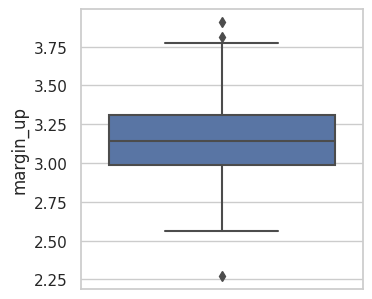

In [250]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')

df_training = df_training.loc[(df_training['margin_up']>2.40) & (df_training['margin_up']<3.75)]
df_training

In [251]:
df_training_vf = df_training.drop(['diagonal','length','height_right','height_left'],axis=1)
df_training_vf.head()

,is_genuine,margin_low,margin_up
0,1,4.52,2.89
1,1,3.77,2.99
2,1,4.40,2.94
3,1,3.62,3.01
4,1,4.04,3.48




4.   Nous faisons une régression linéaire (OLS) sur les deux variables que nous souhaitons conserver




In [252]:
reg_multi_lin = smf.ols('margin_low~+is_genuine+margin_up ', data=df_training_vf).fit()
print(reg_multi_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):          6.00e-304
Time:                        15:26:39   Log-Likelihood:                -765.65
No. Observations:                1456   AIC:                             1537.
Df Residuals:                    1453   BIC:                             1553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9157      0.200     29.550      0.0

# **IV. Insertion des données manquantes prédites**


Construire le df final avec les valeurs manquantes prédites


In [253]:
prediction = df_testing.drop(['diagonal','height_left','height_right','length'],axis=1)

valeurs_pred = reg_multi_lin.predict(prediction)
df_testing['margin_low_pred'] = valeurs_pred

In [254]:
df_final = billets.copy()
df_final.loc[df_testing.index, 'margin_low'] = df_testing['margin_low_pred']
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [255]:
df_final.shape

(1500, 7)

In [256]:
df_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [257]:
df_final.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482836,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659845,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


# **V. Résidus**

In [259]:
x_test = df_final.loc[:,['is_genuine','margin_up']]
y_test = df_final['margin_low']

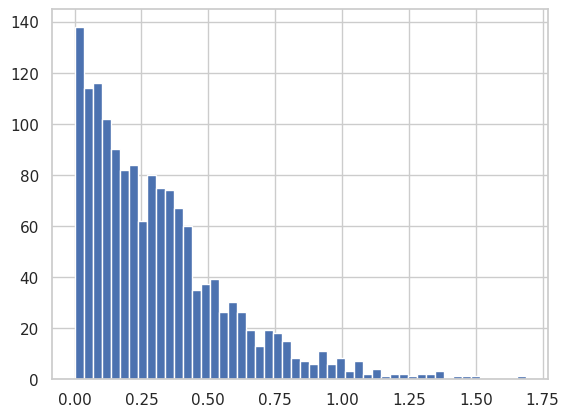

In [260]:
# Représentation de nos erreurs avec un histogramme
y_pred=reg_multi.predict(x_test)
erreur_hi=np.abs(y_test-y_pred)
plt.hist(erreur_hi,bins=50)
plt.show()

Vérifier la normalités des résidus 

In [261]:
# Moyenne des résidus
moy_residus = y_test-y_pred
moy_residus .mean()

-2.6481781043209196e-05

<ipython-input-262-52c200da1817>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(moy_residus)


<Axes: ylabel='Density'>

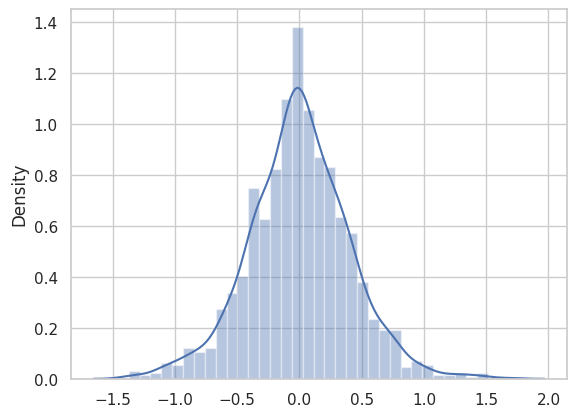

In [262]:
sns.distplot(moy_residus)

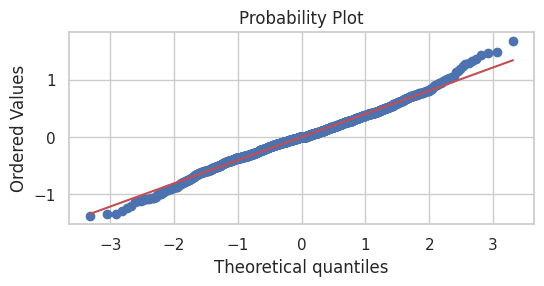

In [263]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(moy_residus, plot=ax, fit=True)




*   Vérifier la colinéarité des variables


Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [264]:
variables = reg_multi_lin.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.586122883225347, 1.586122883225347]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [265]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_lin.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.321149750524877e-36


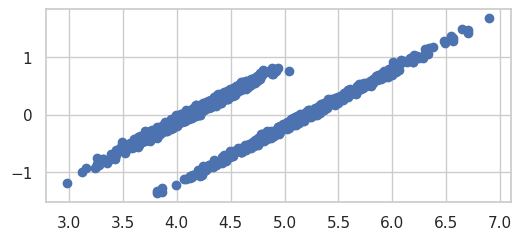

In [266]:
fig, ax = plt.subplots(figsize=(6,2.5))
_= ax.scatter(y_test,moy_residus)

# **VI. Modélisation**

Ici, nous allons séparer notre jeu de données (jeu de test et jeu d’entrainement).

In [273]:
import numpy as np

sample = np.random.randint(70000, size=5000)
data = df_final.drop("margin_low", axis=1)
target = df_final["margin_low"]

In [274]:
# Creation de x_train et y_train pour spliter le df (80% et 20%):
x_train = df_final.drop("margin_low", axis=1)
y_train = df_final["margin_low"]

In [275]:
x_train, x_test, y_train, y_test = train_test_split(df_final.drop(["is_genuine"],axis=1), df_final[["is_genuine"]], test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1200, 6)
(300, 6)
(1200, 1)
(300, 1)


Nous standardisons nos données :

In [276]:
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train_std = std_scale.transform(x_train)
x_test_std = std_scale.transform(x_test)

In [277]:
x_train_std.shape

(1200, 6)

In [278]:
x_test_std.shape

(300, 6)

# **a) Régression  Logistique - Classification**

Nous allons tester deux librairies Python pour obtenir les meilleures prédictions:


*   Statsmodels avec la fonction Logit();
*   Scikit-learn avec LogisticRegression()





1. LogisticRegression()

L'objectif d'une régression logistique est de créer un modèle prédictif. 
Nous souhaitons expliquer une variable qualitative (vrai/faux) par des données quantitatives = regression logistique.
Nous devons donc isoler les données quantitatives et qualitatives. 


In [279]:
#regression logistique
model_LR = LogisticRegression()
#modélisation sur les données d'apprentissage
modele_sk = model_LR.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [280]:
print(modele_sk)

LogisticRegression()


In [ ]:
#calcul des probabilités d'affectation sur l'échantillon test
probas = model_LR.predict_proba(x_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

In [321]:
#score de presence : Probalilité de chance que le billet soit FAUX (is_genuine = 1)
score = probas[:,1]

In [283]:
x_test["probas_faux_sk"] = score
x_test

,diagonal,height_left,height_right,margin_low,margin_up,length,probas_faux_sk
1413,171.83,104.42,104.03,6.000000,2.95,112.98,0.075087
1498,172.06,104.28,104.06,5.170000,3.46,112.25,0.018036
806,171.91,103.99,103.76,3.620000,3.04,113.00,0.998573
1121,171.40,104.38,104.19,5.252158,3.17,112.39,0.042921
312,172.07,104.09,103.70,4.110000,3.00,113.19,0.996625
...,...,...,...,...,...,...,...
915,172.37,104.11,104.09,4.780000,3.09,113.42,0.954129
956,172.22,103.72,103.80,4.360000,3.22,112.84,0.954771
215,172.05,104.08,103.66,4.490000,3.24,113.23,0.979271
227,171.69,103.80,104.10,4.320000,2.69,113.52,0.998889


In [284]:
# Données qualitatives
y = df_final.loc[:, df_final.columns == "is_genuine"]
print(y.value_counts())

# Données quantitatives
#Il faut ajouter une constante dans Statsmodels
x = df_final.loc[:, df_final.columns != "is_genuine"]
x = sm.tools.add_constant(x)                      
print(x.head())

is_genuine
1             1000
0              500
dtype: int64
   const  diagonal  height_left  height_right  margin_low  margin_up  length
0    1.0    171.81       104.86        104.95        4.52       2.89  112.83
1    1.0    171.46       103.36        103.66        3.77       2.99  113.09
2    1.0    172.69       104.48        103.50        4.40       2.94  113.16
3    1.0    171.36       103.91        103.94        3.62       3.01  113.51
4    1.0    171.73       104.28        103.46        4.04       3.48  112.54


In [285]:
from sklearn.metrics import confusion_matrix
x_test = x_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
conf_matrix = confusion_matrix(y_test, model_LR.predict(x_test))
df_conf = pd.DataFrame(conf_matrix, columns=['réel Vrai',"réel Faux"])
df_conf.index = ['prédit Vrai',"prédit Faux"]
df_conf

,réel Vrai,réel Faux
prédit Vrai,113,1
prédit Faux,1,185


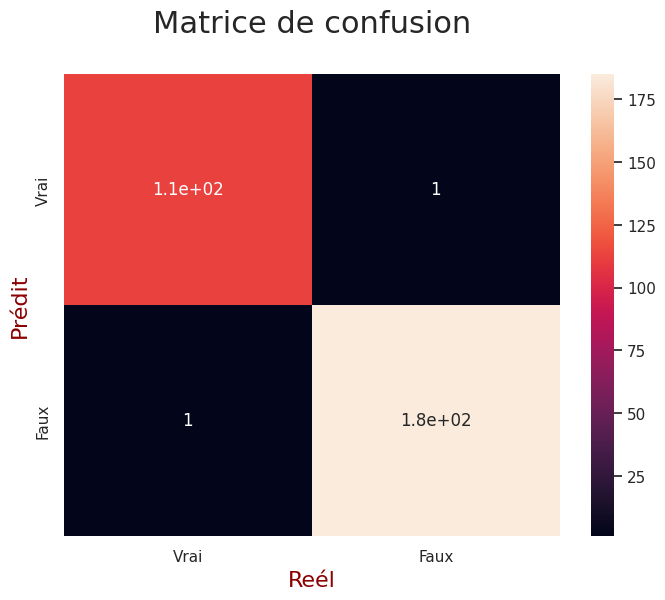

In [286]:
import seaborn as sns
#Affichage avec Seaborn
fig = plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"])

font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel("Reél", fontdict=font)
plt.ylabel("Prédit", fontdict=font)
plt.title("Matrice de confusion\n", fontsize=22)
plt.show()

2. Logit();

In [287]:
# on ajuste le modèle
model = sm.Logit(y, x)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Fri, 31 Mar 2023   Pseudo R-squ.:                  0.9586
Time:                        15:26:57   Log-Likelihood:                -39.487
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -231.2872    249.976     -0.925      0.355    -721.231     258.657
diagonal         0.268

Il y a des variables non-significatives au seuil alpha 5%.
Nous pouvons recommencer la régression logistique sans les variables: diagonal, height_left, height_right.


In [288]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
x2 = df_final[["height_right","margin_low", "margin_up", "length"]]
x2 = sm.add_constant(df_final)

# On recommence la regression logistique:
reg_log = sm.Logit(y, x2)
result2 = model.fit()

# Resume des resultats:
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.959   
Dependent Variable:   is_genuine       AIC:              92.9738 
Date:                 2023-03-31 15:26 BIC:              130.1664
No. Observations:     1500             Log-Likelihood:   -39.487 
Df Model:             6                LL-Null:          -954.77 
Df Residuals:         1493             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -231.2872 249.9759 -0.9252 0.3548 -721.2311 258.6566
diagonal        0.2683   1.1369  0.2360 0.8134   -1.9600   2.4965

In [289]:
# Application du modele sur les donnees training:
df_final["proba"] = result2.predict(x)
df_final["y_pred"] = (result2.predict(x) >= 0.5).astype(int)
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
0,1,171.81,104.86,104.95,4.52,2.89,112.83,0.815234,1
1,1,171.46,103.36,103.66,3.77,2.99,113.09,0.999995,1
2,1,172.69,104.48,103.50,4.40,2.94,113.16,0.999823,1
3,1,171.36,103.91,103.94,3.62,3.01,113.51,0.999999,1
4,1,171.73,104.28,103.46,4.04,3.48,112.54,0.832792,1


[[49100.   900.]
 [  300. 99700.]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

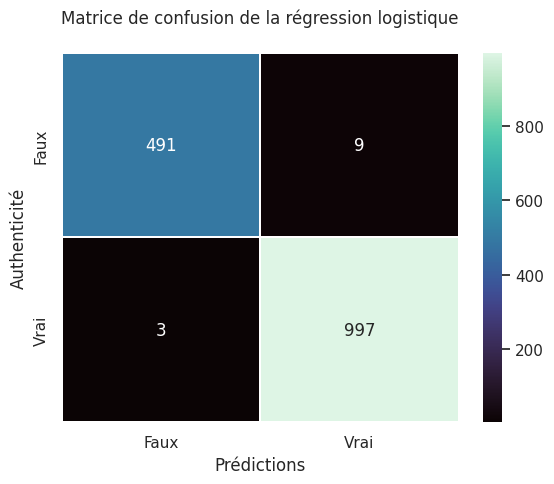

In [290]:
# Matrice de confusion:
confusion_matrice_reg_log = result2.pred_table()
prct = (confusion_matrice_reg_log*100)


print(prct)

# Graphique:
sns.heatmap(confusion_matrice_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

# **b) K-NN**

In [ ]:
# Knn
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

In [ ]:
# Calcul du taux d'erreur
error = 1 - knn.score(x_test, y_test)
print('Erreur: %f' % error)

In [ ]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(4)
knn.fit(x_train, y_train)

# On récupère les prédictions sur les données test
predicted = knn.predict(x_test)

print(predicted)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

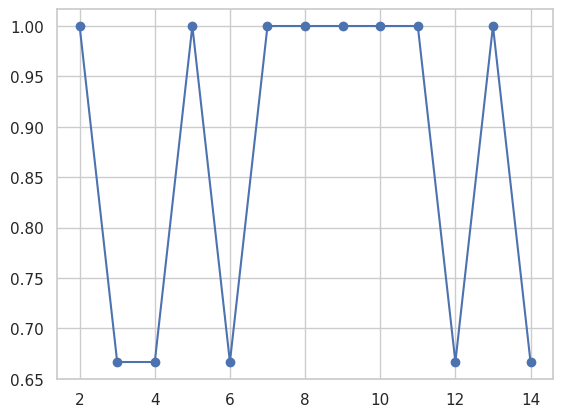

In [323]:
# Optimisation du score sur les données test
import matplotlib.pyplot as plt

errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(x_train,y_train).score(x_test,y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [326]:
# Utilisation de la méthode "GridSearchCV" pour faire une validation croisée du paramètre k

from sklearn import model_selection
# Fixer les valeurs des hyperparamètres à tester
param_grid =  {'n_neighbors': range(2,16) }
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf1 = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf1.fit(x_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf1.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf1.cv_results_['mean_test_score'], # score moyen
        clf1.cv_results_['std_test_score'],  # écart-type du score
        clf1.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}
Résultats de la validation croisée :
accuracy = 0.986 (+/-0.015) for {'n_neighbors': 2}
accuracy = 0.990 (+/-0.011) for {'n_neighbors': 3}
accuracy = 0.991 (+/-0.010) for {'n_neighbors': 4}
accuracy = 0.992 (+/-0.009) for {'n_neighbors': 5}
accuracy = 0.990 (+/-0.011) for {'n_neighbors': 6}
accuracy = 0.992 (+/-0.009) for {'n_neighbors': 7}
accuracy = 0.990 (+/-0.011) for {'n_neighbors': 8}
accuracy = 0.991 (+/-0.011) for {'n_neighbors': 9}
accuracy = 0.990 (+/-0.011) for {'n_neighbors': 10}
accuracy = 0.988 (+/-0.014) for {'n_neighbors': 11}
accuracy = 0.988 (+/-0.014) for {'n_neighbors': 12}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 13}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 14}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 15}


/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [296]:
# afficher les : vrais négatifs, vrais positifs, fauxnégatifs, faux positifs
tn0, fp0, fn0, tp0 = confusion_matrix(y_test,clf1.predict(x_test)).ravel()
tn0, fp0, fn0, tp0
print('Vrais négatifs :',tn0,"\n"'Vrais positifs :',tp0,"\n"'Faux négatifs :',fn0,"\n"'Faux positifs :',fp0)

Vrais négatifs : 112 
Vrais positifs : 185 
Faux négatifs : 1 
Faux positifs : 2


# **c) K-Means**

In [297]:
kmeans = df_final.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [328]:
# Selectionner des valeurs 
X = kmeans.values

#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Utilisation de la methode "ward"
Z = linkage(X_scaled, method="ward")
Z[:2]

#On applique ensuite la fonction fclusters de scipypour définir les clusters :
#Identification des 7 groupes obtenus
clusters = fcluster(Z, 2, criterion='maxclust')
clusters

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

Méthode du coude

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

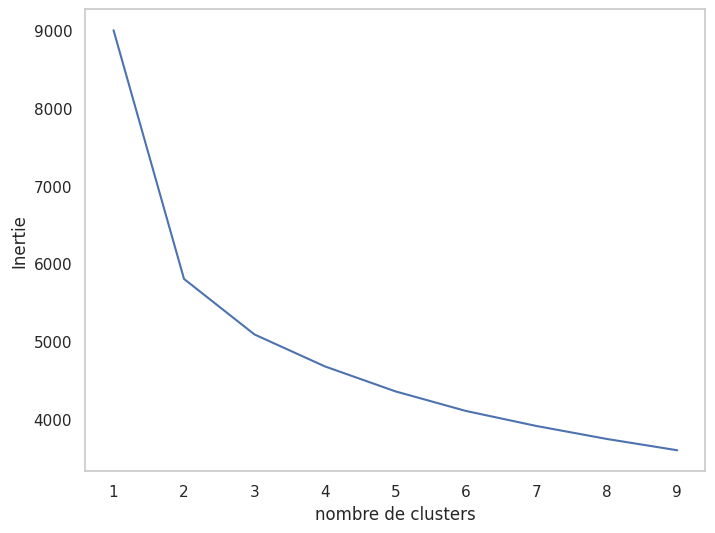

Inertie totale : 3598.551574246573


In [300]:
inertia = []
k_range=range(1,10)
for k in k_range:
    modelkm=KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(modelkm.inertia_)
   
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie')
plt.grid() 
plt.show()
print('Inertie totale :',modelkm.inertia_)

2 clusters bien visibles

Application K-means

In [301]:
# Défition de 2 clusters (comme nous l'avons vu) sur notre modèle et nous l'entrainons le sur le jeu d'entrainement
n_clust = 2

# K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster :
clusters_km = km.labels_

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [302]:
# Integrtion du cluster dans le df
df_final['Cluster'] = clusters_km

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred,Cluster
0,1,171.81,104.86,104.95,4.52,2.89,112.83,8.152336e-01,1,0
1,1,171.46,103.36,103.66,3.77,2.99,113.09,9.999946e-01,1,0
2,1,172.69,104.48,103.50,4.40,2.94,113.16,9.998235e-01,1,0
3,1,171.36,103.91,103.94,3.62,3.01,113.51,9.999990e-01,1,0
4,1,171.73,104.28,103.46,4.04,3.48,112.54,8.327918e-01,1,0
...,...,...,...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28,1.515830e-03,0,1
1496,0,172.19,104.63,104.44,5.27,3.37,110.97,2.897928e-08,0,1
1497,0,171.80,104.01,104.12,5.51,3.36,111.95,1.444860e-05,0,1
1498,0,172.06,104.28,104.06,5.17,3.46,112.25,2.226165e-04,0,1


In [303]:
# Repérer le Cluster correspondant à is_genuine = False
cross_kmeans = pd.crosstab(df_final['Cluster'], df_final['is_genuine']).reset_index()
cluster_false = cross_kmeans[cross_kmeans[False] > cross_kmeans[True]].Cluster

In [304]:
#affichage des différences
Kemansdiff = df_final[((df_final['is_genuine'] == True) & (df_final['Cluster'] == int(cluster_false))) | ((df_final['is_genuine'] == False) & (df_final['Cluster'] != int(cluster_false)))]
Kemansdiff

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred,Cluster
591,1,171.67,103.81,103.76,4.59,3.30,112.18,0.089042,0,1
728,1,171.94,104.11,104.16,4.08,3.35,111.76,0.022082,0,1
1024,0,171.52,104.05,104.31,4.24,3.70,112.60,0.023081,0,0
1025,0,172.17,104.20,104.13,3.86,3.38,112.44,0.798659,1,0
1073,0,172.13,103.67,103.82,4.27,3.22,112.15,0.591385,1,0
1078,0,172.21,104.40,104.28,5.28,3.42,112.99,0.007156,0,0
1081,0,171.82,103.90,103.67,4.79,3.36,112.43,0.079818,0,0
1083,0,171.85,103.60,103.82,4.60,3.21,112.50,0.650191,1,0
1087,0,171.91,104.28,103.86,5.48,3.37,113.13,0.030009,0,0
1103,0,171.88,104.05,103.75,4.41,3.21,112.52,0.821210,1,0


In [305]:
print("Il y a une marge d'erreur de",round((df_diff.shape[0]/n)*100,2),"% sur nos",n,"individus.")

Il y a une marge d'erreur de 1.4 % sur nos 1500 individus.


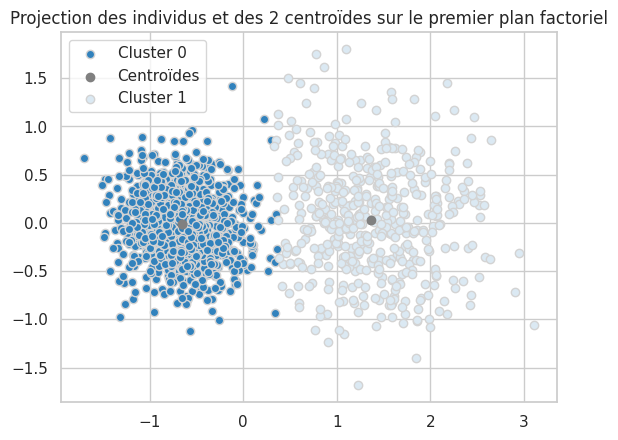

In [306]:
# Représentation des centroides :
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

Graphique du coefficient de silhouette

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['var', 'mean', 'sample', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


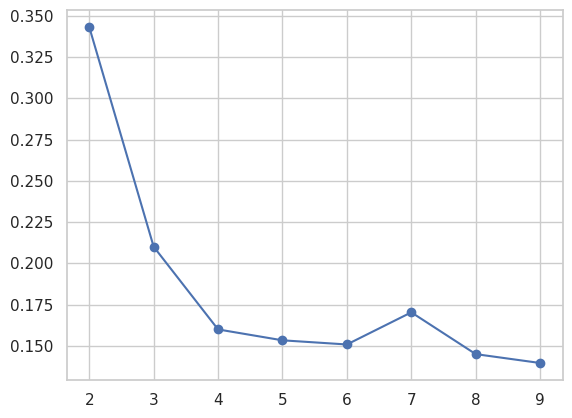

In [307]:
%pylab inline
from sklearn import cluster, metrics

silhouettes = []

for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters = num_clusters,
                         n_init=1, init="random")
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2,10), silhouettes, marker='o')

In [ ]:
from sklearn.metrics import silhouette_score
#Use silhouette score
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)

for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters).fit(df_final)
    preds = clusterer.predict(df_final)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df_final, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Matrice de confusion

In [309]:
#Matrice de confusion pour Kmeans (verification de la classification)
Kmeans_matrice = pd.crosstab(clusters_km,df_final["is_genuine"])
print(Kmeans_matrice)

is_genuine    0    1
row_0               
0            19  998
1           481    2


Text(0.5, 1.0, 'Matrice de confusion pour K-means\n')

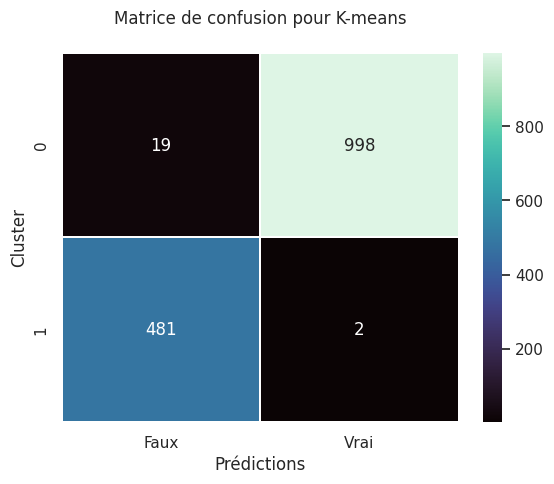

In [310]:
# Graphique:
sns.heatmap(Kmeans_matrice,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion pour K-means\n")

# **d) La courbe de ROC**

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


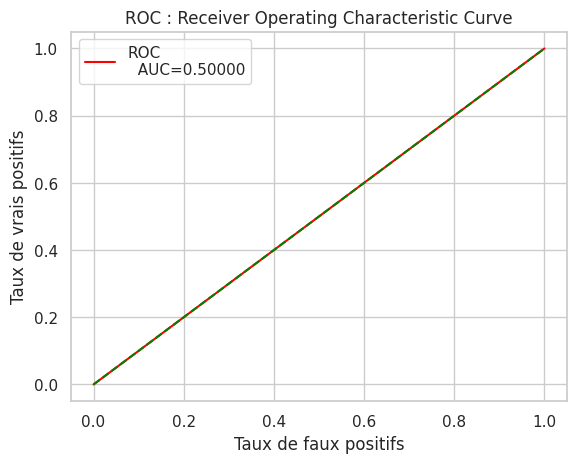

In [311]:
def plot_roc_curve(fauxpos, vraineg):
    aucf =metrics.auc(fauxpos, vraineg)
    plt.plot(fauxpos, vraineg, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('ROC : Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()


prob = km.predict(X_scaled)

# inverser les valeur tel que vrai billet=1 et faux billet=0
a = 1-prob

fauxpos, vraineg, thresholds = roc_curve(df_final['is_genuine'], a)
plot_roc_curve(fauxpos, vraineg)

# **VII. Conclusion / Déploiement du modèle**

La regression logistique est le meilleur modèle pour répondre aux exigences

In [312]:
# enregistrer le modèle
import pickle
pickle.dump(modele_sk, open("modele_sk.pkl", "wb"))

# **VIII. TEST JEU DE DONNÉES SOUTENANCE**

In [313]:
billets_production.head()

,Probabilité que le billet soit VRAI (%),Est authentique ?
0,99.48,Oui
1,99.90,Oui
2,99.87,Oui
3,8.21,Non
4,0.04,Non


In [314]:
billets_production = pd.read_csv('billets_production.csv',sep=',')
test_soutenance = billets_production.drop(["id"],axis=1)

# standardisation des données
std_scale = preprocessing.StandardScaler().fit(test_soutenance)
X_scaled_soutenance = std_scale.transform(test_soutenance)
test_soutenance.loc[test_soutenance.index,"préd"] = modele_sk.predict(X_scaled_soutenance)

# Affichage des prédictions
affichage_result= []
for i in test_soutenance['préd'] :
    if i == 1 :
        affichage_result.append('Vrai Billet')
        
    else :
        affichage_result.append('Faux Billet')

test_soutenance['prédiction'] = affichage_result

# Afficher le résultat en chiffre
print(test_soutenance['préd'].value_counts())

test_soutenance.head()


0.0    3
1.0    2
Name: préd, dtype: int64


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,diagonal,height_left,height_right,margin_low,margin_up,length,préd,prédiction
0,171.76,104.01,103.54,5.21,3.30,111.42,0.0,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,0.0,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,0.0,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,1.0,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,1.0,Vrai Billet


In [315]:

liste_X = ["diagonal","height_left","height_right","margin_low","margin_up","length","id"]

#creation des variables 
X_new = billets_production[liste_X[:-1]]

# standardisation des données
std_scale_2 = preprocessing.StandardScaler().fit(X_new)
X_scaled_proba = std_scale.transform(X_new)


#calcul des probabilités d'affectation sur l'échantillon exemple
probas_new = modele_sk.predict_proba(X_new)


#score de presence : Probalilité de chance que le billet soit VRAI (is_genuine = 0)
score_new = probas_new[:,0]


#Ajout de la colonne probabilité
billets_production["proba_true"] = score_new
#calcul de la variable is_genuine
billets_production["is_genuine"] = np.where(billets_production["proba_true"]>=0.5, 'Oui', 'Non')
#traitement du Dataframe pour meilleure compréhension :
billets_production = billets_production[["proba_true","is_genuine"]].rename(columns={"id":"Identifiant du billet testé",
                                                                                 "proba_true":"Probabilité que le billet soit VRAI (%)",
                                                                                 "is_genuine":"Est authentique ?"})
billets_production["Probabilité que le billet soit VRAI (%)"] = round((billets_production["Probabilité que le billet soit VRAI (%)"]*100),2)

In [316]:
billets_production

,Probabilité que le billet soit VRAI (%),Est authentique ?
0,99.44,Oui
1,99.90,Oui
2,99.86,Oui
3,8.16,Non
4,0.04,Non
